# Creating Manipulation Station in a Robot Library

In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import numpy as np
import trimesh
import sys
from typing import List 
from IPython.display import clear_output, SVG
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    Concatenate,
    DiagramBuilder,
    MeshcatVisualizer,
    MeshcatVisualizerParams,
    Parser,
    PointCloud,
    RigidTransform,
    StartMeshcat,
    UniformlyRandomRotationMatrix,
    Context,
    Diagram,
    PointCloud,
    Simulator,
    TrajectorySource,
    Solve,
    RotationMatrix,
    MultibodyPlant
)
from pydrake.geometry import Meshcat
from pydrake.multibody import inverse_kinematics

from manipulation.station import MakeHardwareStation, load_scenario
from manipulation.meshcat_utils import AddMeshcatTriad
from manipulation import running_as_notebook
from manipulation.scenarios import AddFloatingRpyJoint, AddRgbdSensors, ycb, AddMultibodyTriad, MakeManipulationStation
from manipulation.utils import ConfigureParser
from manipulation.clutter import GraspCandidateCost, GenerateAntipodalGraspCandidate
from manipulation.icp import IterativeClosestPoint
from manipulation.station import AddPointClouds

# Own utils
from hwstation.add_objects import get_library_scenario_data, get_library_scenario_data_without_robot
from enum import Enum
import matplotlib.pyplot as plt
from hwstation.utils import visualize_diagram, init_diagram, fix_input_port, filterCollsionGeometry, get_iiwa_joint_state

## 1. Run simulation

In [3]:
# Start meshcat
try:
    meshcat = Meshcat(7006)
except:
    pass #This error appears if this cell is executed twice (port 7006 is already taken then)

scenario_data = get_library_scenario_data()
diagram_plan, visualizer, simulator = init_diagram(meshcat, scenario_data)
fix_input_port(diagram_plan, simulator)
diagram_plan_context = diagram_plan.CreateDefaultContext()
scene_graph = diagram_plan.GetSubsystemByName("station").GetSubsystemByName("scene_graph")
sg_context = scene_graph.GetMyContextFromRoot(diagram_plan_context)
filterCollsionGeometry(scene_graph, sg_context)
q0_home = get_iiwa_joint_state(diagram_plan, diagram_plan_context)
simulator.AdvanceTo(1.0)


INFO:drake:Meshcat listening for connections at http://localhost:7006


Station input port size:  <pydrake.systems.framework.InputPort object at 0x7fff8d663a30>
plant.GetStateNames():  102
plant.GetActuatorNames():  12
Fixing input port of size:  20
Fixing input port of size:  1


==== LCM Warning ===
LCM detected that large packets are being received, but the kernel UDP
receive buffer is very small.  The possibility of dropping packets due to
insufficient buffer space is very high.

For more information, visit:
   http://lcm-proj.github.io/lcm/multicast_setup.html



In [4]:
station = diagram_plan.GetSubsystemByName("station")
station_context = station.GetMyContextFromRoot(diagram_plan_context)

## 2. Plot camera views

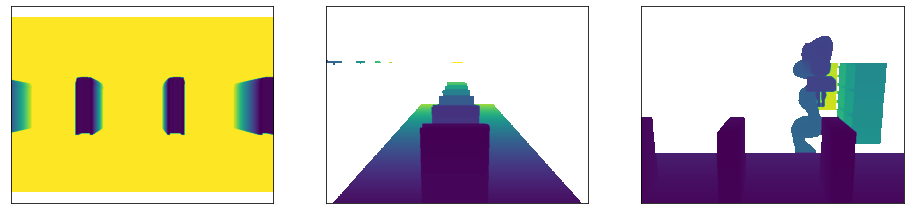

In [7]:
fig, axs = plt.subplots(1,3,figsize=(16,4))
for idx,camera_idx in enumerate([0,1,6]):
    depth_image = station.GetOutputPort(f"table_camera_{camera_idx}.depth_image").Eval(station_context)
    axs[idx].imshow(depth_image.data.squeeze())
    #axs[idx].set_title(f"camera_{idx}")
    axs[idx].set_xticks([])
    axs[idx].set_yticks([])
plt.savefig("figures/depth_images.png")

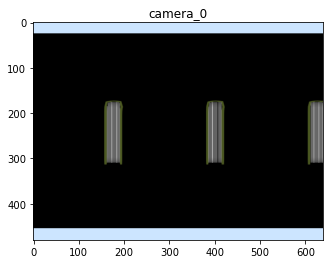

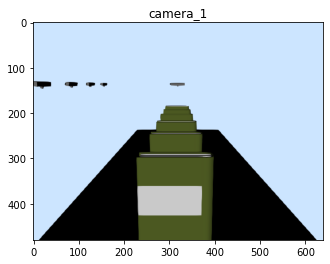

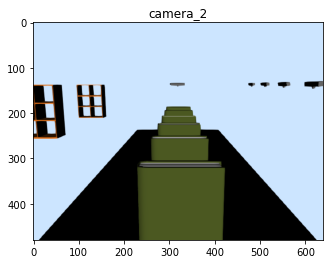

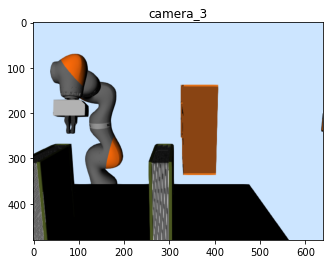

<Figure size 432x288 with 0 Axes>

In [8]:
for camera_idx in range(4):
    depth_image = station.GetOutputPort(f"table_camera_{camera_idx}.rgb_image").Eval(station_context)
    plt.imshow(depth_image.data)
    plt.title(f"camera_{camera_idx}")
    plt.show()
    plt.savefig(f"figures/{camera_idx}.jpg")

In [9]:
from perception.icp import *
from hwstation.utils import visualize_frame

Unaligned frames:

In [ ]:
icp_cloud_list, X_MS_hat_list = run_table_multi_book_icp(diagram_plan, diagram_plan_context, meshcat,icp_limit=10,visualize=True, align_frames=False)
for idx, X_MS_hat in enumerate(X_MS_hat_list):
    visualize_frame(str(idx),meshcat, X_MS_hat)

Aligned frames:

In [10]:
icp_cloud_list, X_MS_hat_list = run_table_multi_book_icp(diagram_plan, diagram_plan_context, meshcat,icp_limit=10,visualize=True, align_frames=True)
for idx, X_MS_hat in enumerate(X_MS_hat_list):
    visualize_frame(str(idx),meshcat, X_MS_hat)

fixing improper rotation
fixing improper rotation
fixing improper rotation
Retrying fitting idx=2
fixing improper rotation
fixing improper rotation
